# Build a Convolutional Neural Network (CNN) model to classify images from a given dataset into predefined categories/classes.

3/4 final layers max
optimizer= adam could be ok
number of filters

### Importing general dependencies

In [1]:
#Import general dependencies

import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, AveragePooling2D, Input, Add, Flatten, Dropout, MaxPool2D
from keras.initializers import glorot_uniform as gu
from keras.models import Model
from keras.utils import plot_model
from keras.preprocessing import image
from keras.utils import image_dataset_from_directory



### Data Loading


In [2]:
!kaggle datasets download -d alessiocorrado99/animals10 -p /content

import zipfile
import os

# Define the path to the zip file
zip_file_path = '/content/animals10.zip'

# Define the directory where you want to extract the files
extract_dir = '/content/animals10/'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
 99% 580M/586M [00:08<00:00, 78.4MB/s]
100% 586M/586M [00:08<00:00, 71.8MB/s]


In [3]:

#Load into a dataset

animals_dir = '/content/animals10/raw-img'

#animals = image_dataset_from_directory(animals_dir, validation_split=0.2, subset="training", seed=123,image_size=(28, 28))

Found 26179 files belonging to 10 classes.
Using 20944 files for training.


#Data Exploration

Explore the Dataset: Get an overview of the data, including the number of classes, number of images per class, and sample images.


In [4]:
# List all classes
class_animals = animals.class_names
print(f"This dataset contains the following classes:\n {class_animals}\n")

# Counting total images per class
image_class = {}
for class_name in class_animals:
    class_dir = os.path.join(animals_dir, class_name)
    image_class[class_name] = len(os.listdir(class_dir))

print("Total images per class:")
for class_name, count in image_class.items():
    print(f"{class_name} : {count}")

This dataset contains the following classes:
 ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

Total images per class:
cane : 4863
cavallo : 2623
elefante : 1446
farfalla : 2112
gallina : 3098
gatto : 1668
mucca : 1866
pecora : 1820
ragno : 4821
scoiattolo : 1862


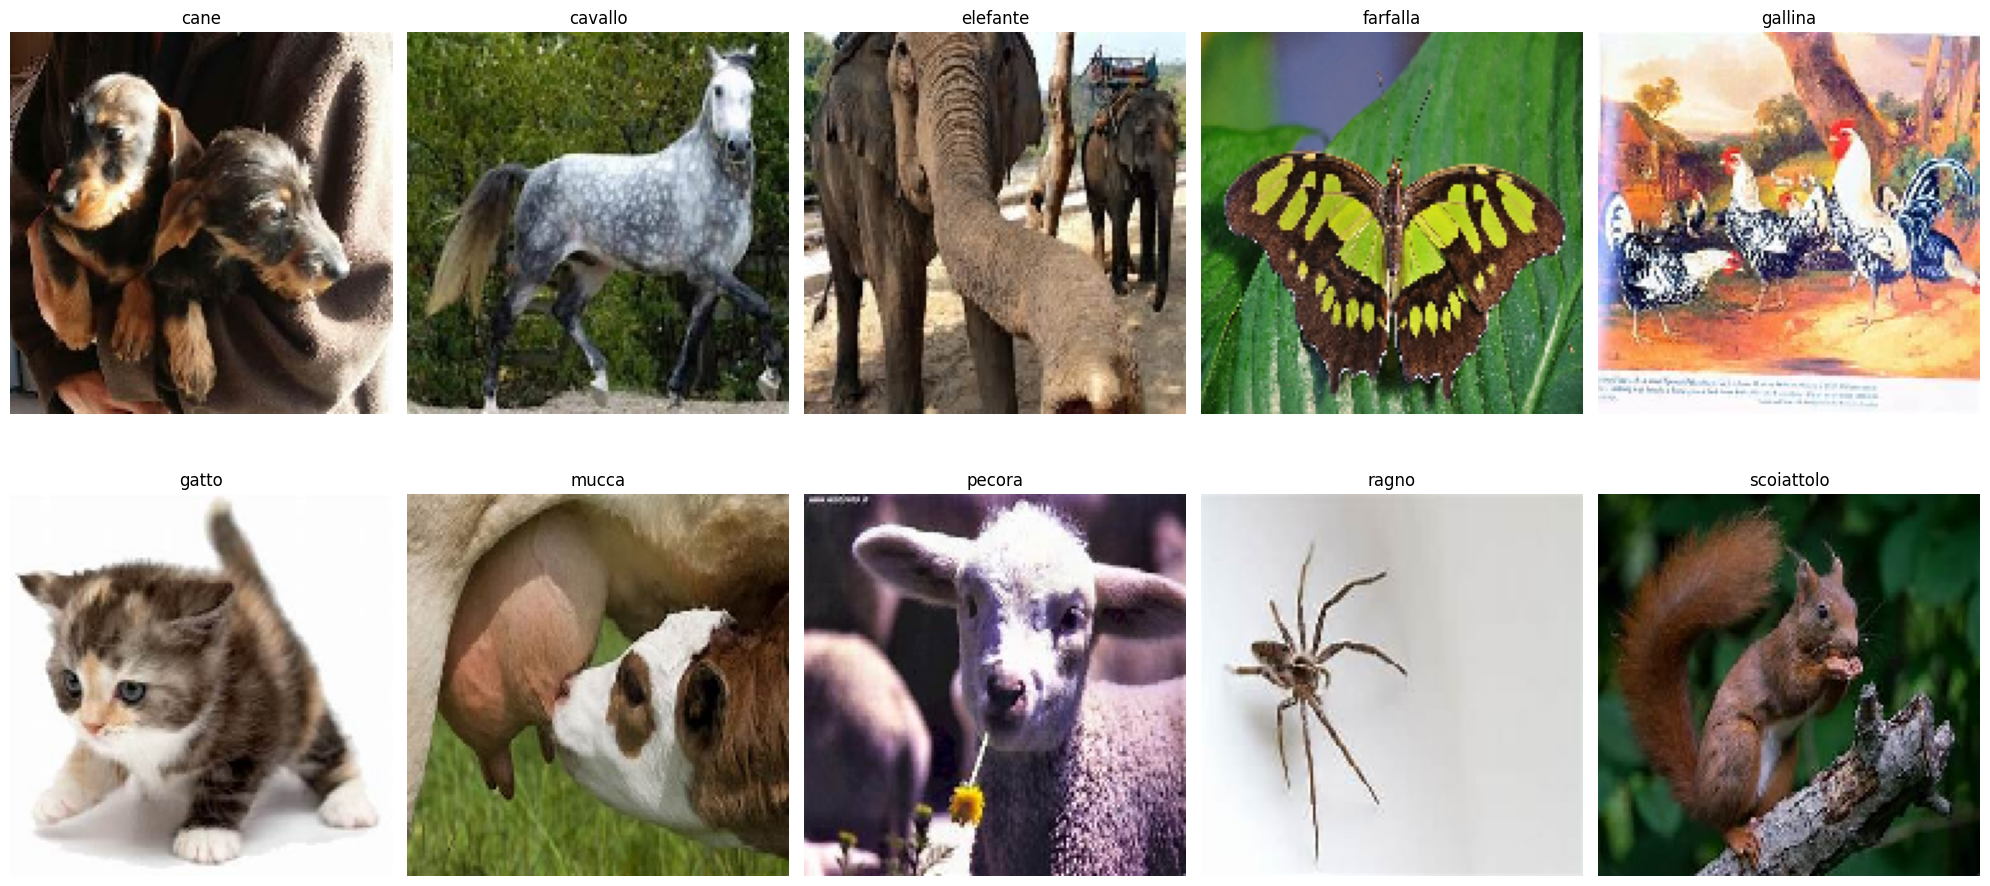

In [5]:
#Plotting sample images from each class
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
axes = axes.flatten()
for ax, class_name in zip(axes, class_animals):
    class_dir = os.path.join(animals_dir, class_name)
    file_list = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    if file_list:
      path_sample = os.path.join(class_dir, file_list[0])  # Selecting the first file
      img = image.load_img(path_sample, target_size=(150, 150))
      ax.imshow(img)
      ax.set_title(class_name)
      ax.axis('off')
    else:
      continue
plt.tight_layout()
plt.show()

### Data Preprocessing

Preprocessing (e.g., normalization, resizing, augmentation).
Create visualizations of some images, and labels.


In [9]:
from keras.preprocessing.image import ImageDataGenerator


data_generator = ImageDataGenerator(
    rescale=1./255.0, #normalizes pixel values from 0-255 to 0-1
    horizontal_flip=True, #randomly flips images horizontally
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    validation_split=0.2) #splits the data into train and test sets



#Split into train and test sets

train_set = data_generator.flow_from_directory(
    animals_dir,
    target_size=(64,64),
    batch_size = 1024,
    class_mode="categorical",
    subset="training"
)

validation_set = data_generator.flow_from_directory(
    animals_dir,
    target_size=(64,64),
    batch_size = 1024,
    class_mode="categorical",
    subset="validation"
)
test_data_generator = ImageDataGenerator(rescale= 1./255.0)
test_set = test_data_generator.flow_from_directory(
    animals_dir,
    target_size=(64,64),
    batch_size = 1024,
    class_mode="categorical",
    subset="validation"
)

AttributeError: 'ImageDataGenerator' object has no attribute 'image_dataset_from_directory'

Model Architecture

Design a CNN architecture suitable for image classification.
Include convolutional layers, pooling layers, and fully connected layers.
Model Training

Train the CNN model using appropriate optimization techniques (e.g., stochastic gradient descent, Adam).
Utilize techniques such as early stopping to prevent overfitting.
Model Evaluation

Evaluate the trained model on a separate validation set.
Compute and report metrics such as accuracy, precision, recall, and F1-score.
Visualize the confusion matrix to understand model performance across different classes.
Transfer Learning

Evaluate the accuracy of your model on a pre-trained models like ImagNet, VGG16, Inception... (pick one an justify your choice)
You may find this link helpful.
This is the Pytorch version.
Perform transfer learning with your chosen pre-trained models i.e., you will probably try a few and choose the best one.

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


# cnn_model = tf.keras.models.Sequential([
#     Conv2D(64, (3,3), activation='relu',input_shape=(28,28,3)),
#     MaxPool2D((2,2)),


#     Conv2D(128, (3,3), activation='relu'),
#     MaxPool2D((2,2)),

#     Conv2D(256, (3,3), activation='relu'),
#     MaxPool2D((2,2)),

#     Flatten(),
#     Dense(256, activation="relu"),
#     Dropout(0.5),

#     Dense(10, activation="softmax"),
# ]
# )

cnn_model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64,64, 3)),
    #Conv2D(32, (3, 3), activation='relu'),
    MaxPool2D((2,2)),


    Conv2D(64, (3, 3), activation='relu'),
    #Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D((2,2)),


    Conv2D(128, (3, 3), activation='relu'),
    #Conv2D(128, (3, 3), activation='relu'),
    MaxPool2D((2,2)),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),

    Dense(10, activation="softmax"),
]
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



early_stopping = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)



In [ ]:
print(len(train_set))

cnn_model.summary()


41
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)       

In [ ]:
history = cnn_model.fit(train_set, validation_data = validation_set, epochs=20, callbacks=[early_stopping, reduce_lr], verbose=2)

Epoch 1/20
21/21 - 245s - loss: 2.2021 - accuracy: 0.2025 - val_loss: 2.1180 - val_accuracy: 0.2554 - lr: 0.0010 - 245s/epoch - 12s/step
Epoch 2/20
21/21 - 243s - loss: 2.0864 - accuracy: 0.2589 - val_loss: 1.9948 - val_accuracy: 0.2953 - lr: 0.0010 - 243s/epoch - 12s/step
Epoch 3/20
21/21 - 235s - loss: 2.0010 - accuracy: 0.2985 - val_loss: 1.9114 - val_accuracy: 0.3326 - lr: 0.0010 - 235s/epoch - 11s/step
Epoch 4/20


In [ ]:
test_loss, test_acc = cnn_model.evaluate(test_set)
print(f"Test accuracy: {test_acc}")